In [1]:
from pprint import pprint
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Import data, vectorization, and train/test split

In [2]:
df = pd.read_csv('data/presidential_speeches_cleaned.csv', encoding='utf-8', usecols=['Party', 'Cleaned'])
df.sample(5)

,Party,Cleaned
537,Democratic,garland senator brewster senator tydings membe...
755,Democratic,fellow americans today armed forces joined nat...
803,Democratic,madam speaker vice president members congress ...
693,Republican,many friends thank tonight thank voters suppor...
130,Democratic,senate united states received copy resolution ...


In [3]:
enc = LabelEncoder()
enc.fit(df['Party'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the confusion matrices
df['Party'] = enc.transform(df['Party'])
encoded_labels

{'Democratic': 0, 'Republican': 1}

In [4]:
X = df.drop('Party',axis=1)
y = df['Party']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=97, stratify=y)

In [5]:
vect = TfidfVectorizer()

preprocess = make_column_transformer(
    (vect, 'Cleaned'),
    remainder='drop'
)

## Models

### Logistic Regression

In [6]:
lr_clf = LogisticRegression(class_weight='balanced')

lr_pipe = make_pipeline(preprocess, lr_clf)

In [7]:
lr_param_grid = {
    'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__max_iter': [100, 250, 500, 750, 1000],
    'columntransformer__tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]
}

In [8]:
lr_gs = GridSearchCV(lr_pipe, lr_param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=10, refit=True)
lr_gs.fit(X_train, y_train)

print(f"{lr_gs.best_score_:.3f}")
pprint(lr_gs.best_params_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
0.796
{'columntransformer__tfidfvectorizer__ngram_range': (2, 2),
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}


In [9]:
y_pred_sgd = lr_gs.predict(X_test)

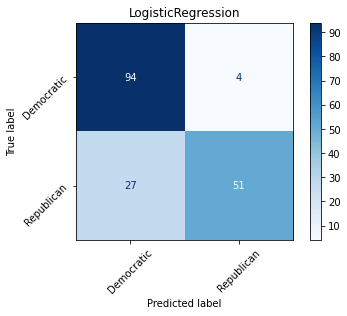

In [10]:
cm = confusion_matrix(y_test, y_pred_sgd, labels=lr_gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.display_labels = encoded_labels
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title(lr_clf.__class__.__name__)
disp.ax_.tick_params(axis='both', rotation=45)

In [17]:
lr_param_grid2 = {
    'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag'],
    'logisticregression__penalty': ['l2'],
    'logisticregression__max_iter': [100, 250, 500, 750, 1000],
    'columntransformer__tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]
}

In [18]:
lr_gs2 = GridSearchCV(lr_pipe, lr_param_grid2, cv=10, scoring='f1_macro', n_jobs=-1, verbose=10, refit=True)
lr_gs2.fit(X_train, y_train)

print(f"{lr_gs2.best_score_:.3f}")
pprint(lr_gs2.best_params_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
0.794
{'columntransformer__tfidfvectorizer__ngram_range': (2, 2),
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}


In [19]:
y_pred_sgd2 = lr_gs2.predict(X_test)

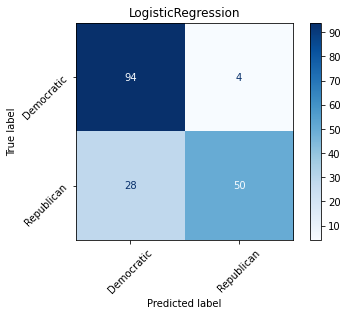

In [20]:
cm = confusion_matrix(y_test, y_pred_sgd2, labels=lr_gs2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.display_labels = encoded_labels
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title(lr_clf.__class__.__name__)
disp.ax_.tick_params(axis='both', rotation=45)

### SVM

In [11]:
svm = SVC(kernel='linear')

svm_pipe = make_pipeline(preprocess, svm)

In [12]:
svm_param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'columntransformer__tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]
}

In [13]:
svm_gs = GridSearchCV(svm_pipe, svm_param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=10, refit=True)
svm_gs.fit(X_train, y_train)

print(f"{svm_gs.best_score_:.3f}")
pprint(svm_gs.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
0.846
{'columntransformer__tfidfvectorizer__ngram_range': (1, 2), 'svc__C': 10}


In [14]:
y_pred_svm = svm_gs.predict(X_test)

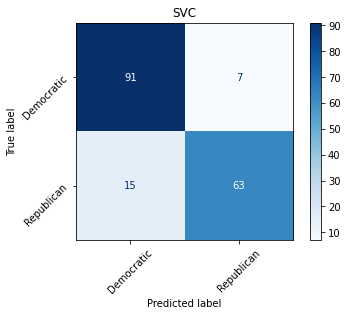

In [16]:
cm = confusion_matrix(y_test, y_pred_svm, labels=svm_gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.display_labels = encoded_labels
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title(svm.__class__.__name__)
disp.ax_.tick_params(axis='both', rotation=45);